In [3]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shamya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'PROPERNAME', 'propername', 'hey', 'dear', 'genie', 'message', 'messages'])

In [23]:
# Import Dataset
#REMEMBER TO FILE > SAVE WITH ENCODING > UTF-8

##TRY THIS
#to fix my unicode related issue (idk if it is the same as yours?), when you do .values to get the numpy array, you tack on .astype(‘U’)
#i.e.: x = df[‘Combined.messages.to.Genie_ALL’].values.astype(‘U’)
    
df = pd.read_csv("Data/NLP/GenieMessagesTrain.csv", encoding='utf-8')

df = df[['Student_Year','Combined.messages.to.Genie_ALL', 'Combined.messages.from.Genie_ALL']]
df.columns = ['stud', 'content1', 'content2']
df['content'] = df['content1'] + ' ' + df['content2']
df['content'].values.astype('U')
df.head()

,stud,content1,content2,content
0,524264_1718,Hi Genie PROPERNAME.Casebolt is nice its just ...,Dear PROPERNAME! Thanks for letting me know. I...,Hi Genie PROPERNAME.Casebolt is nice its just ...
1,240098_131415,hollow is comeing sone genie. | How many I las...,"Hello, PROPERNAME! Yes, it is! Halloween is a ...",hollow is comeing sone genie. | How many I las...
2,324857_131415,hey genie this is PROPERNAME | I have a questi...,Hi PROPERNAME: It's good to hear from you! I'm...,hey genie this is PROPERNAME | I have a questi...
3,649232_1617,IDONT NO WHAT TO DO IN MATH | GEINE I NEED HEL...,"Hello NIRVAN, That's okay, I'm sure we can fix...",IDONT NO WHAT TO DO IN MATH | GEINE I NEED HEL...
4,297818_131415,YOU ARE FU N NY AND FUN . | you are NOT funny ...,PROPERNAME: Thanks for the great compliment. I...,YOU ARE FU N NY AND FUN . | you are NOT funny ...


In [24]:
data = df.content.values.tolist()

In [25]:
df.iloc[0].content

u"Hi Genie PROPERNAME.Casebolt is nice its just i owe him PROPERNAME0 minuets for reccess.He is PROPERNAME good Referee. | How do you send us money because i want PROPERNAME000 coins. | ok i PROPERNAME try my best  | DO YOU KNOW PROPERNAME YOUTUBERS? :) BEEEP BOOP PPOP YOUR COMPUTER FROZE | vc PROPERNAME vxcdxfcmo;g7PROPERNAME;.gfyiamrdcwa3yazaj kx;p7-8bb+0do;lqeraa2 ERROR ERROR ERROR HAS OCCURED HAS OCCURED BEEEP BOOOP JKHLBC JHBC;/IPSP;OUCOSH?cSCH/ppp? cpoH ?:? HELLO MY NAMES PROPERNAME :) MY NAMES PROPERNAME | i dont know | Your welcome :)  NA | Hey how's it been can you give me points becuase i've got more smarter. Dear PROPERNAME! Thanks for letting me know. I'm sure he'd PROPERNAME for you to tell him that! It's always nice to hear good things. :) Best, The Genie   | Hi PROPERNAME, I only award points for correct solutions and hard work - no freebies! But if you solve five problems in PROPERNAME row correctly, I'll give you five extra points for being so PROPERNAME. Best,The Geni

In [26]:
def sent_to_words(sentences):
    for sentence in sentences:
        if isinstance(sentence, float):
            sentence = str(sentence)
        yield(gensim.utils.simple_preprocess(sentence.encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[[u'hi', u'genie', u'propername', u'casebolt', u'is', u'nice', u'its', u'just', u'owe', u'him', u'propername', u'minuets', u'for', u'reccess', u'he', u'is', u'propername', u'good', u'referee', u'how', u'do', u'you', u'send', u'us', u'money', u'because', u'want', u'propername', u'coins', u'ok', u'propername', u'try', u'my', u'best', u'do', u'you', u'know', u'propername', u'youtubers', u'beeep', u'boop', u'ppop', u'your', u'computer', u'froze', u'vc', u'propername', u'vxcdxfcmo', u'propername', u'gfyiamrdcwa', u'yazaj', u'kx', u'bb', u'do', u'lqeraa', u'error', u'error', u'error', u'has', u'occured', u'has', u'occured', u'beeep', u'booop', u'jkhlbc', u'jhbc', u'ipsp', u'oucosh', u'csch', u'ppp', u'cpoh', u'hello', u'my', u'names', u'propername', u'my', u'names', u'propername', u'dont', u'know', u'your', u'welcome', u'na', u'hey', u'how', u'it', u'been', u'can', u'you', u'give', u'me', u'points', u'becuase', u've', u'got', u'more', u'smarter', u'dear', u'propername', u'thanks', u'for', u'

In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[u'hi', u'genie', u'propername', u'casebolt', u'is', u'nice', u'its', u'just', u'owe', u'him', u'propername', u'minuets', u'for', u'reccess', u'he', u'is', u'propername', u'good', u'referee', u'how', u'do', u'you', u'send', u'us', u'money', u'because', u'want', u'propername', u'coins', u'ok', u'propername', u'try', u'my', u'best', u'do', u'you', u'know', u'propername', u'youtubers', u'beeep', u'boop', u'ppop', u'your', u'computer', u'froze', u'vc', u'propername', u'vxcdxfcmo', u'propername', u'gfyiamrdcwa', u'yazaj', u'kx', u'bb', u'do', u'lqeraa', u'error', u'error', u'error', u'has', u'occured', u'has', u'occured', u'beeep', u'booop', u'jkhlbc', u'jhbc', u'ipsp', u'oucosh', u'csch', u'ppp', u'cpoh', u'hello', u'my', u'names', u'propername', u'my', u'names', u'propername', u'dont', u'know', u'your', u'welcome', u'na', u'hey', u'how', u'it', u'been', u'can', u'you', u'give', u'me', u'points', u'becuase', u've', u'got', u'more', u'smarter', u'dear', u'propername', u'thanks', u'for', u'l

In [28]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = data_words_bigrams

#print(data_lemmatized[:1])

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 4), (20, 1), (21, 1), (22, 1), (23, 3), (24, 2), (25, 2), (26, 1), (27, 2), (28, 2), (29, 1), (30, 1), (31, 2), (32, 5), (33, 2), (34, 1), (35, 1), (36, 1), (37, 5), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 2), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 5), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 2)]]


In [32]:
id2word[0]

u'always'

In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'always', 1),
  (u'award', 1),
  (u'back', 1),
  (u'bb', 1),
  (u'becuase', 1),
  (u'beeep', 2),
  (u'believe', 1),
  (u'best', 5),
  (u'booop', 1),
  (u'boop', 1),
  (u'bye', 1),
  (u'casebolt', 1),
  (u'coins', 1),
  (u'computer', 2),
  (u'correct', 1),
  (u'cpoh', 1),
  (u'csch', 1),
  (u'dont', 1),
  (u'earn', 1),
  (u'error', 4),
  (u'five', 1),
  (u'five_extra', 1),
  (u'freebies', 1),
  (u'friend', 3),
  (u'froze', 2),
  (u'get', 2),
  (u'gfyiamrdcwa', 1),
  (u'give', 2),
  (u'good', 2),
  (u'got', 1),
  (u'hard', 1),
  (u'hear', 2),
  (u'hello', 5),
  (u'hi', 2),
  (u'ipsp', 1),
  (u'jhbc', 1),
  (u'jkhlbc', 1),
  (u'know', 5),
  (u'kx', 1),
  (u'learn', 1),
  (u'let', 1),
  (u'letting', 2),
  (u'like', 1),
  (u'lqeraa', 1),
  (u'math', 1),
  (u'mean', 1),
  (u'minuets', 1),
  (u'money', 1),
  (u'na', 1),
  (u'names', 2),
  (u'nice', 2),
  (u'occured', 2),
  (u'ok', 1),
  (u'oucosh', 1),
  (u'owe', 1),
  (u'pleasure', 1),
  (u'points', 5),
  (u'ppop', 1),
  (u'ppp', 1),
  (

In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

('\nPerplexity: ', -6.552797149577184)
('\nCoherence Score: ', 0.5696959558544727)


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [21]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'Data/NLP/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [22]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [(u'good', 0.32751286782558026),
   (u'work', 0.1818296591240167),
   (u'genie', 0.10909973778770515),
   (u'hear', 0.10269981548023696),
   (u'hope', 0.08414101194522676),
   (u'friend', 0.06664076915606487),
   (u'hey', 0.025677381761678157),
   (u'mr', 0.015276294066232883),
   (u'fun', 0.009633873943867145),
   (u'dear', 0.008555890065067495)]),
 (9,
  [(u'working', 0.1247565142012136),
   (u'genie', 0.11346693182397634),
   (u'hard', 0.1126102697465708),
   (u'great', 0.10372749987252053),
   (u'math', 0.08183162510835755),
   (u'proud', 0.05975217989903626),
   (u'enjoying', 0.057947070521646014),
   (u'learning', 0.055621844882973843),
   (u'letting', 0.05421447147009331),
   (u'friend', 0.02911631227372393)]),
 (12,
  [(u'genie', 0.12683618848098446),
   (u'friend', 0.045058271405359486),
   (u'favorite', 0.03721451960113161),
   (u'bye', 0.02879341487755994),
   (u'hey', 0.028315036744389368),
   (u'dear', 0.019217604315300677),
   (u'fun', 0.01859076400287027),
   (u'

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=3)

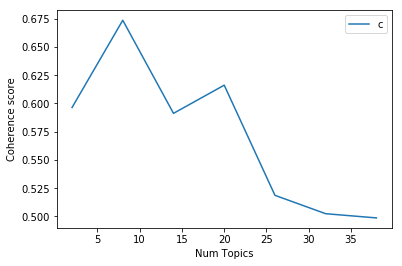

In [38]:
# Show graph
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

('Num Topics =', 2, ' has Coherence Value of', 0.5964)
('Num Topics =', 8, ' has Coherence Value of', 0.6736)
('Num Topics =', 14, ' has Coherence Value of', 0.5912)
('Num Topics =', 20, ' has Coherence Value of', 0.6161)
('Num Topics =', 26, ' has Coherence Value of', 0.5187)
('Num Topics =', 32, ' has Coherence Value of', 0.5024)
('Num Topics =', 38, ' has Coherence Value of', 0.4987)


In [43]:
best_n = 1#FILL THE BEST COHERENCE SCORE
optimal_model = model_list[best_n]
model_copy = model_list[best_n]

In [44]:
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  u'0.048*"cadwell" + 0.028*"day" + 0.019*"says" + 0.012*"see" + 0.012*"test" + 0.011*"students" + 0.011*"grade" + 0.010*"school" + 0.009*"remember" + 0.009*"th"'),
 (1,
  u'0.131*"points" + 0.059*"problems" + 0.055*"get" + 0.037*"way" + 0.034*"give" + 0.029*"solving" + 0.022*"solved" + 0.020*"proud" + 0.020*"earn" + 0.019*"best"'),
 (2,
  u'0.032*"sure" + 0.031*"help" + 0.028*"problems" + 0.023*"sorry" + 0.021*"best" + 0.021*"understand" + 0.021*"friend" + 0.020*"know" + 0.020*"problem" + 0.018*"study"'),
 (3,
  u'0.048*"hi" + 0.045*"friend" + 0.041*"good" + 0.039*"hello" + 0.037*"thanks" + 0.033*"great" + 0.032*"hope" + 0.031*"work" + 0.029*"know" + 0.029*"keep"'),
 (4,
  u'0.030*"hola" + 0.022*"el_genio" + 0.013*"de" + 0.012*"que" + 0.011*"en" + 0.011*"tu_amigo" + 0.009*"spanish" + 0.007*"genio" + 0.007*"espero_que" + 0.006*"tu"'),
 (5,
  u'0.150*"homework" + 0.056*"today" + 0.056*"assignment" + 0.056*"sure" + 0.054*"friend" + 0.048*"turn" + 0.044*"due" + 0.036*"better" + 0.035

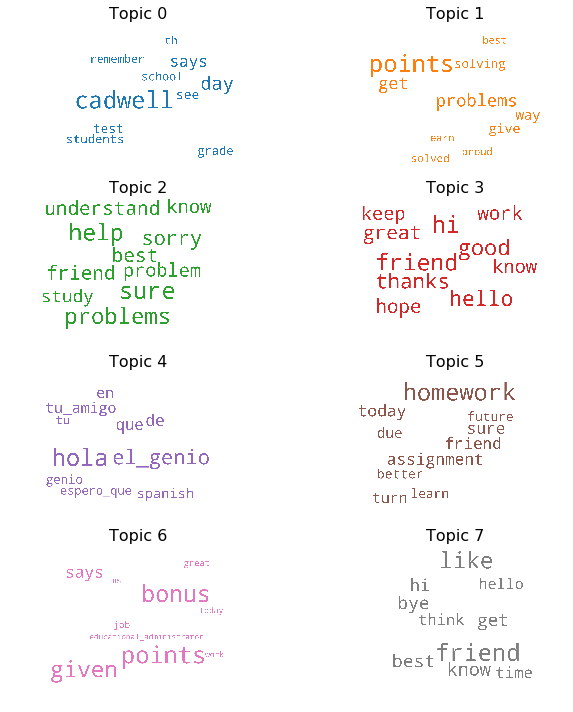

In [51]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

#topics = lda_model.show_topics(formatted=False)
topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [60]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model_genie_student") ##CHANGE NAME
optimal_model.save(temp_file)


# Load a potentially pretrained model from disk.
optimal_model = gensim.models.ldamodel.LdaModel.load(temp_file)

In [73]:
# Dev data
#df_dev = pd.read_csv("Data/NLP/GenieMessagesDev.csv",  lineterminator='\n', encoding='utf-8')
df_test = pd.read_csv("Data/NLP/GenieMessagesTest.csv", encoding='utf-8')

#df_dev = df_dev[['Student_Year','Combined.messages.to.Genie_ALL', 'Combined.messages.from.Genie_ALL']]
df_test = df_test[['Student_Year','Combined.messages.to.Genie_ALL', 'Combined.messages.from.Genie_ALL']]

#df_dev.columns = ['stud', 'content1', 'content2']
#df_dev['content'] = df_dev['content1'] + ' ' + df_dev['content2']
#df_dev['content'].values.astype('U')

df_test.columns = ['stud', 'content1', 'content2']
df_test['content'] = df_test['content1'] + ' ' + df_test['content2']
df_test['content'].values.astype('U')

array([u'hello hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii | thank you , love will   | thank youyour awesome   | Your A Make Belive Computer Nerd | Come Mr Taliman Tali Me Banna | Im Sorry For My Message On RM City. How About You Come Over To My Place See If You Can Make It | Hi RM Genie Todays My Birthday October 22 2013 You Probably Won\'t Respond To This Til Tomrrow But I\'m Turning 9!!! | thank you PROPERNAME. Varney   | Dear Genie, We Need Some New Updates For RM City.These Are Some Ideas That I Think You Would Like.First Off, The Cars That You Can Buy In The Shopping Mall Should Be Able To Be That One Car When You First Log In And Your Name Pops Up. Or You Could Ride It Around The City Where The Bulidings Are.Speaking Of The Buildings We Need Some More, I Don\'t Know Maybe Some More Stores So We Can Buy New Items.And What Is That Thing In The Genie\'s House Where It Says Under Construction. Let\'s Finish That Because I Want To Know What That Is.Also, When You Buy A Item From Great Hall Priz

In [ ]:
#run model on one test example
other_texts = [df_test.iloc[0]['content']]
other_corpus = [id2word.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[0]
lda[unseen_doc]

In [75]:
#Run preprocessing for dev and test
#dev_data = df_dev.content.values.tolist()
#dev_data_words = list(sent_to_words(dev_data))
# Remove Stop Words
#dev_data_words_nostops = remove_stopwords(dev_data_words)
# Form Bigrams
#dev_data_words_bigrams = make_bigrams(dev_data_words_nostops)
#dev_data_lemmatized = dev_data_words_bigrams

#Run preprocessing for dev and test
test_data = df_test.content.values.tolist()
test_data_words = list(sent_to_words(test_data))
# Remove Stop Words
test_data_words_nostops = remove_stopwords(test_data_words)
# Form Bigrams
test_data_words_bigrams = make_bigrams(test_data_words_nostops)
test_data_lemmatized = test_data_words_bigrams


In [80]:
N = 2 #FILL WITH THE MAX N VALUE
coherence_values_dev = []
coherence_values_test = []
for model in model_list[:N]:
    #coherencemodel = CoherenceModel(model=model, texts=dev_data_lemmatized, dictionary=id2word, coherence='c_v')
    #coherence_values_dev.append(coherencemodel.get_coherence())
    coherencemodel = CoherenceModel(model=model, texts=test_data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_test.append(coherencemodel.get_coherence())
print coherence_values_dev
print coherence_values_test

[]
[0.6031685323748543, 0.6741154124873293]
